In [25]:
#================================= Start of importing required packages and libraries =========================================#
from __future__ import print_function
import numpy as np
import argparse
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import *
from matplotlib import pyplot as plt
from dataset import Dataset
from model import Net
import os
from torch.utils import data
%matplotlib inline
import random
import resnet_models
from resnet_models import fixup_resnet20, fixup_resnet32
#================================== End of importing required packages and libraries ==========================================#




#=============================== Defining global variables ========================#

#10 workers in this federated model 
num_of_workers = 10
#10 10 in this federated model classification problem 
num_of_classes = 10
#initialization of reputation values with 0.1 for each worker 
global_reputaion = [0.1 for i in range(num_of_workers)]


#======================================= Fix the model´s seed to reproduce a deterministic results ============================#

#=============================== Start of fixing the model´s seed to reproduce a deterministic results ========================#
def seed_everything(seed=77):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything()
#======================================= Fix the model´s seed to reproduce a deterministic results ============================#




#===================================== Start of classes, lables and workers lists and dictionaries ========================================#
lables_dict = {"airplane":0, 
        "automobile":1,
        "bird":2,
        "cat":3,
        "deer":4,
        "dog":5,
        "frog":6,
        "horse":7,
        "ship":8,
        "truck":9}

classes = ('plane', 'car',  'bird',  'cat',  'deer',
                       'dog',   'frog', 'horse', 'ship', 'truck')

workers = ['Josep', 'David', 'Oriol','Alberto', 'Jesus', 'Michel', 'Fadi', 'Rami', 'Ashneet', 'Najeeb']



#Change the directory to the place of test dataset
os.chdir("d:/Federated_Learning/Applications/cifar_classification_model/")
PATH = os.path.join(os.getcwd(), 'checkpoint')





#======================================= End of classes and lables list and dictionary ========================================#




#======================================= Start of training function ===========================================================#
def train(model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #data = data.transpose(3, 1)
        data=data.float()
        
        #poisoning attack by changing the decision about a dog to be a cat
                
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx > 0 and batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
                (epoch+1), batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        
    return losses
#======================================= End of training function =============================================================#




#======================================= Start of testning function ===========================================================#
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            #data = data.transpose(3, 1)
            data=data.float()
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (float(correct) / len(test_loader.dataset))

#======================================= End of testning function =============================================================#




#======================================= Start of worker´s task function and attack simulation======================================================#
def worker_task(worker_id, epoch, model, device, data_loader, task_type, 
                targeted_poisoning_attack = False, stealthy_poisoning_attack = False):
    
    gradients = []
    accuracy= 0.0
    
    if(task_type == 'train'):
        return gradients
    if(task_type == 'test'):
        return accuracy
#======================================= End of worker´s task function ========================================================#    



#======================================= Start of distribution and loading of the datasets ====================================#
#paths to training and testing datasets
train_path = str(os.getcwd()+"/dataset/train/")
test_path = str(os.getcwd() + "/dataset/test")

# Define a transforms to normalize and augment the data
ransform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_dataset_worker1 = Dataset(train_path, ransform_train, 0, 50000, 32, True)
test_dataset_worker1 = Dataset(test_path, transform_test,  0, 10000, 32, True) 


len_of_training_samples = len(train_dataset_worker1)
len_of_testing_samples = len(test_dataset_worker1)


train_loader = data.DataLoader(
   train_dataset_worker1,
    batch_size=3,
    shuffle=True,
    num_workers=1)

test_loader = data.DataLoader(
    test_dataset_worker1,
    batch_size=1,
    shuffle=False,
    num_workers=1)
#======================================= End of istribution and loading of the datasets =======================================#



#=================================Start of model creation and distribute workers tasks ========================================#
model = Net()

#model = fixup_resnet20()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cpu") # or 'gpu'
losses = []
accuracies = []
best_accuracy = 0.0
#start training
print("=======> Start training......")
for epoch in range(0, 20):
    losses.extend(train(model, device, train_loader, optimizer, epoch))
    currenet_accuracy = test(model, device, test_loader)
    accuracies.append(currenet_accuracy)
    print('\nAccuracy with testing dataset:\t({:.0f}%)\n'.format(100. * currenet_accuracy))
    
    # Save the new model just if there is an accuracy improvement
    if currenet_accuracy > best_accuracy:
        best_accuracy = currenet_accuracy
        torch.save(model.state_dict(), os.path.join(PATH, '{}_cifar_net.pth'.format(epoch+1)))
    #if epoch > 15:
        #for param_group in optimizer.param_groups:
            #param_group['lr'] *= 0.97
#=================================End of model creation and distribute workers tasks ========================================#


=======> loading training dataset......

=======> loading testing dataset......

=======> Start training......
Train Epoch: 1 [3000/50000	(6%)]	Loss: 2.313391
Train Epoch: 1 [6000/50000	(12%)]	Loss: 2.302585
Train Epoch: 1 [9000/50000	(18%)]	Loss: 2.228259
Train Epoch: 1 [12000/50000	(24%)]	Loss: 2.053606
Train Epoch: 1 [15000/50000	(30%)]	Loss: 1.886490
Train Epoch: 1 [18000/50000	(36%)]	Loss: 1.651686
Train Epoch: 1 [21000/50000	(42%)]	Loss: 1.423890
Train Epoch: 1 [24000/50000	(48%)]	Loss: 3.000331
Train Epoch: 1 [27000/50000	(54%)]	Loss: 1.582496
Train Epoch: 1 [30000/50000	(60%)]	Loss: 1.563260
Train Epoch: 1 [33000/50000	(66%)]	Loss: 2.193592
Train Epoch: 1 [36000/50000	(72%)]	Loss: 2.781371
Train Epoch: 1 [39000/50000	(78%)]	Loss: 1.973148
Train Epoch: 1 [42000/50000	(84%)]	Loss: 0.372588
Train Epoch: 1 [45000/50000	(90%)]	Loss: 1.152727
Train Epoch: 1 [48000/50000	(96%)]	Loss: 1.078793

Average loss: 1.3503, Accuracy: 5184/10000 (52%)


Accuracy with testing dataset:	(52%)

Tra

Train Epoch: 10 [9000/50000	(18%)]	Loss: 1.326339
Train Epoch: 10 [12000/50000	(24%)]	Loss: 1.584698
Train Epoch: 10 [15000/50000	(30%)]	Loss: 1.832106
Train Epoch: 10 [18000/50000	(36%)]	Loss: 0.457854
Train Epoch: 10 [21000/50000	(42%)]	Loss: 0.354668
Train Epoch: 10 [24000/50000	(48%)]	Loss: 1.216440
Train Epoch: 10 [27000/50000	(54%)]	Loss: 0.667812
Train Epoch: 10 [30000/50000	(60%)]	Loss: 1.234678
Train Epoch: 10 [33000/50000	(66%)]	Loss: 1.021697
Train Epoch: 10 [36000/50000	(72%)]	Loss: 1.496578
Train Epoch: 10 [39000/50000	(78%)]	Loss: 0.455090
Train Epoch: 10 [42000/50000	(84%)]	Loss: 0.701474
Train Epoch: 10 [45000/50000	(90%)]	Loss: 0.980303
Train Epoch: 10 [48000/50000	(96%)]	Loss: 1.377606

Average loss: 0.9572, Accuracy: 6692/10000 (67%)


Accuracy with testing dataset:	(67%)

Train Epoch: 11 [3000/50000	(6%)]	Loss: 0.349777
Train Epoch: 11 [6000/50000	(12%)]	Loss: 1.149585
Train Epoch: 11 [9000/50000	(18%)]	Loss: 0.632518
Train Epoch: 11 [12000/50000	(24%)]	Loss: 0.6866

Train Epoch: 19 [12000/50000	(24%)]	Loss: 0.091919
Train Epoch: 19 [15000/50000	(30%)]	Loss: 0.151852
Train Epoch: 19 [18000/50000	(36%)]	Loss: 0.601016
Train Epoch: 19 [21000/50000	(42%)]	Loss: 1.244764
Train Epoch: 19 [24000/50000	(48%)]	Loss: 0.680239
Train Epoch: 19 [27000/50000	(54%)]	Loss: 0.557384
Train Epoch: 19 [30000/50000	(60%)]	Loss: 0.212457
Train Epoch: 19 [33000/50000	(66%)]	Loss: 0.725716
Train Epoch: 19 [36000/50000	(72%)]	Loss: 0.922828
Train Epoch: 19 [39000/50000	(78%)]	Loss: 0.755937
Train Epoch: 19 [42000/50000	(84%)]	Loss: 2.463084
Train Epoch: 19 [45000/50000	(90%)]	Loss: 0.152519
Train Epoch: 19 [48000/50000	(96%)]	Loss: 0.174053

Average loss: 0.9082, Accuracy: 7017/10000 (70%)


Accuracy with testing dataset:	(70%)

Train Epoch: 20 [3000/50000	(6%)]	Loss: 0.772022
Train Epoch: 20 [6000/50000	(12%)]	Loss: 1.945763
Train Epoch: 20 [9000/50000	(18%)]	Loss: 0.939498
Train Epoch: 20 [12000/50000	(24%)]	Loss: 0.518352
Train Epoch: 20 [15000/50000	(30%)]	Loss: 1.032

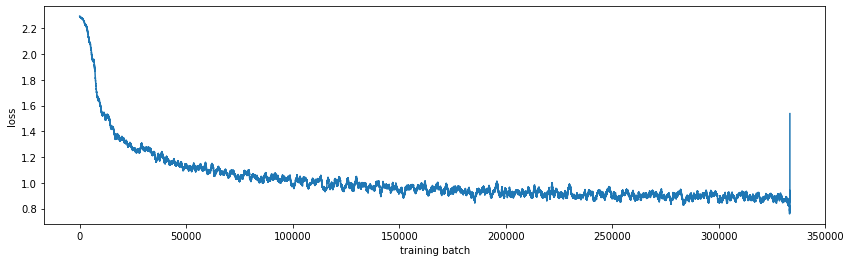

In [26]:
def mean(li): return sum(li)/len(li)
plt.figure(figsize=(14, 4))
plt.xlabel('training batch')
plt.ylabel('loss')
plt.plot([mean(losses[i:i+1000]) for i in range(len(losses))])

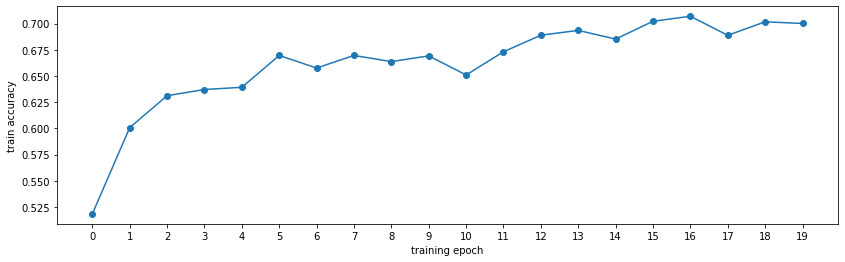

In [27]:
plt.figure(figsize=(14, 4))
plt.xticks(range(len(accuracies)))
plt.xlabel('training epoch')
plt.ylabel('train accuracy')
plt.plot(accuracies, marker='o')

Confusion matrix:
[[793  43  17  14   3   3   8  15  18  86]
 [  9 891   2   5   0   1   1   6   2  83]
 [100  24 511  40  32  87  87  80   6  33]
 [ 48  24  44 485  28 154  64  86  11  56]
 [ 35  18  48  69 550  58  72 123   4  23]
 [ 29  16  42 162  18 611  24  75   6  17]
 [ 10  21  29  46  15  36 796  17   1  29]
 [ 23  16  24  29  16  39  11 809   3  30]
 [105  83  10  10   3   3   6   8 696  76]
 [ 16  89   2   5   0   1   7  14   7 859]]
F1 score: 0.700100
Accuracy score: 0.700100


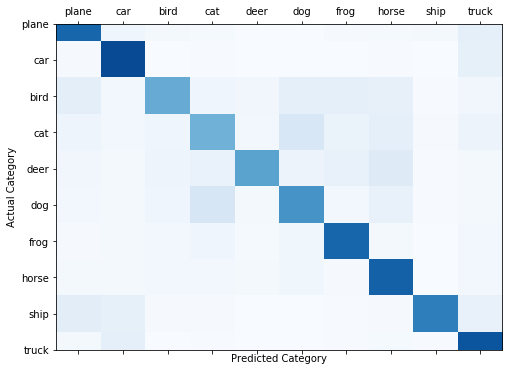

Category   - Accuracy
plane      - 79.3
car        - 89.1
bird       - 51.1
cat        - 48.5
deer       - 55.0
dog        - 61.1
frog       - 79.6
horse      - 80.9
ship       - 69.6
truck      - 85.9


In [28]:
 #classes = ('plane', 'car',  'bird',  'cat',  'deer',
  #         'dog',   'frog', 'horse', 'ship', 'truck')
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data=data.float()
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]


actuals, predictions = test_label_predictions(model, device, test_loader)
print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))


fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix(actuals, predictions), aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()


print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix(actuals, predictions)):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

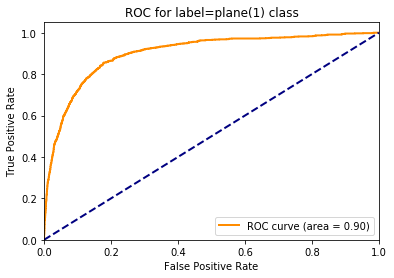

In [20]:
def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            #data = data.transpose(3, 1)
            data=data.float()
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction) == which_class)
            probabilities.extend(np.exp(output[:, which_class]))
    return [i.item() for i in actuals], [i.item() for i in probabilities]

which_class = 1
actuals, class_probabilities = test_class_probabilities(model, device, test_loader, which_class)

fpr, tpr, _ = roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for label=plane(%d) class' % which_class)
plt.legend(loc="lower right")
plt.show()

In [21]:
#print model trainable parameters

total = 0
print('\nTrainable parameters:')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, '\t', param.numel())
        total += param.numel()
print()
print('Total', '\t', total, "trainable parametsers")


Trainable parameters:
conv1.weight 	 864
conv2.weight 	 18432
fc1.weight 	 524288
fc2.weight 	 1280

Total 	 544864 trainable parametsers
